In [26]:
# === Cargar el CSV robustamente (Windows-friendly) ===
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, pearsonr, spearmanr
import statsmodels.api as sm
from math import sqrt



In [27]:
pd.set_option('display.max_columns', 120)
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
print("OK: librerías importadas")

OK: librerías importadas


In [28]:
def find_file(filename: str, start: Path = None) -> Path:
    start = start or Path.cwd()
    candidate = start / filename
    if candidate.exists():
        return candidate
    found = list(start.rglob(filename))
    if not found:
        raise FileNotFoundError(f"No encuentro {filename} desde {start}")
    return found[0]

In [29]:
def auto_map_columns(df, want={
    "category": ["category","categories","main_category","product_category","cat"],
    "isBestSeller": ["isbestseller","best_seller","bestSeller","is_best_seller","bestseller","is_bestseller"],
    "price": ["price","sale_price","current_price","prices"],
    "stars": ["stars","rating","ratings","review_stars","star_rating"]
}):
    cols_lower = {c.lower(): c for c in df.columns}
    mapping = {}
    for target, candidates in want.items():
        hit = None
        for cand in candidates:
            if cand.lower() in cols_lower:
                hit = cols_lower[cand.lower()]
                break
        if hit is None:
            print(f"[AVISO] No detecté columna para '{target}'. Ajusta manualmente.")
        mapping[target] = hit
    return mapping

In [30]:
def cramers_v_corrected(confusion):
    chi2, p, dof, expected = chi2_contingency(confusion)
    n = confusion.to_numpy().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    # corrección de Bergsma
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    v = sqrt(phi2corr/denom) if denom > 0 else np.nan
    return chi2, p, dof, v

In [31]:
def iqr_mask(s, k=1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    return (s >= q1 - k*iqr) & (s <= q3 + k*iqr)

In [32]:
# === 1) Carga de datos ===
CSV_NAME = "amz_uk_price_prediction_dataset.csv"  # tu archivo

csv_path = find_file(CSV_NAME)
print("Leyendo:", csv_path)
df = pd.read_csv(csv_path)
print("Dimensiones:", df.shape)
display(df.head(3))

# === 1.1) Mapeo automático de columnas clave ===
map_cols = auto_map_columns(df)
map_cols

Leyendo: c:\Users\cubea\OneDrive\Documentos\GitHub\lab-eda-bivariate\amz_uk_price_prediction_dataset.csv
Dimensiones: (2443651, 9)


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.700,15308,21.990,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.700,98099,23.990,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.700,15308,21.990,False,0,Hi-Fi Speakers


{'category': 'category',
 'isBestSeller': 'isBestSeller',
 'price': 'price',
 'stars': 'stars'}

In [33]:
# === 2) Normalizar tipos de datos básicos ===
cat_col   = map_cols["category"]
best_col  = map_cols["isBestSeller"]
price_col = map_cols["price"]
stars_col = map_cols["stars"]

# A: conversión numérica básica
if price_col:
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
if stars_col:
    df[stars_col] = pd.to_numeric(df[stars_col], errors="coerce")

# B: isBestSeller a 0/1 si existe
if best_col:
    # muchas veces viene como bool, 'Yes/No', 'True/False', etc.
    if df[best_col].dtype == bool:
        df[best_col] = df[best_col].astype(int)
    else:
        # convierte strings comunes a 0/1
        df[best_col] = (
            df[best_col]
            .astype(str)
            .str.strip()
            .str.lower()
            .replace({"true":1,"yes":1,"y":1,"1":1,"false":0,"no":0,"n":0,"0":0})
        )
        df[best_col] = pd.to_numeric(df[best_col], errors="coerce").fillna(0).astype(int)

# C: drop NAs imprescindibles
need = [c for c in [cat_col, price_col, stars_col] if c]
df = df.dropna(subset=need)
print("Tras limpieza mínima:", df.shape)
df[need].head(3)

Tras limpieza mínima: (2443651, 9)


,category,price,stars
0,Hi-Fi Speakers,21.990,4.700
1,Hi-Fi Speakers,23.990,4.700
2,Hi-Fi Speakers,21.990,4.700


In [34]:
# === 3) Crosstab y proporciones ===
assert cat_col and best_col, "Falta 'category' o 'isBestSeller'"

ct = pd.crosstab(df[cat_col], df[best_col])
ct_prop = ct.div(ct.sum(axis=1), axis=0)

print("Crosstab (conteos):")
display(ct.sort_index().head())

print("\nCrosstab (proporciones por categoría):")
display(ct_prop.sort_index().head())

if 1 in ct_prop.columns:
    top_prop = ct_prop[1].sort_values(ascending=False)
    print("\nTop categorías por proporción de best-seller:")
    display(top_prop.head(20))
else:
    print("[AVISO] No hay columna '1' en isBestSeller; revisa codificación.")

Crosstab (conteos):


isBestSeller,0,1
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3



Crosstab (proporciones por categoría):


isBestSeller,0,1
category,,
3D Printers,0.996,0.004
3D Printing & Scanning,1.000,0.000
Abrasive & Finishing Products,0.980,0.020
Action Cameras,0.999,0.001
Adapters,0.988,0.012



Top categorías por proporción de best-seller:


category
Grocery                          0.058
Smart Home Security & Lighting   0.058
Health & Personal Care           0.058
Mobile Phone Accessories         0.042
Power & Hand Tools               0.035
Billiard, Snooker & Pool         0.032
Pet Supplies                     0.030
Home Brewing & Wine Making       0.028
Wind Instruments                 0.028
Mirrors                          0.028
Professional Medical Supplies    0.027
PC & Video Games                 0.025
Bakeware                         0.025
Material Handling Products       0.025
Bedding Accessories              0.024
Tableware                        0.024
Arts & Crafts                    0.024
Baby                             0.023
Lighting                         0.023
Window Treatments                0.021
Name: 1, dtype: float64

In [35]:
# === 4) Test Chi² y Cramér's V ===
chi2, p, dof, v = cramers_v_corrected(ct)
print(f"Chi² = {chi2:,.3f} | dof = {dof} | p-value = {p:.6f}")
print(f"Cramér's V (corregido) = {v:,.4f}")

Chi² = 36,540.203 | dof = 295 | p-value = 0.000000
Cramér's V (corregido) = 0.1218


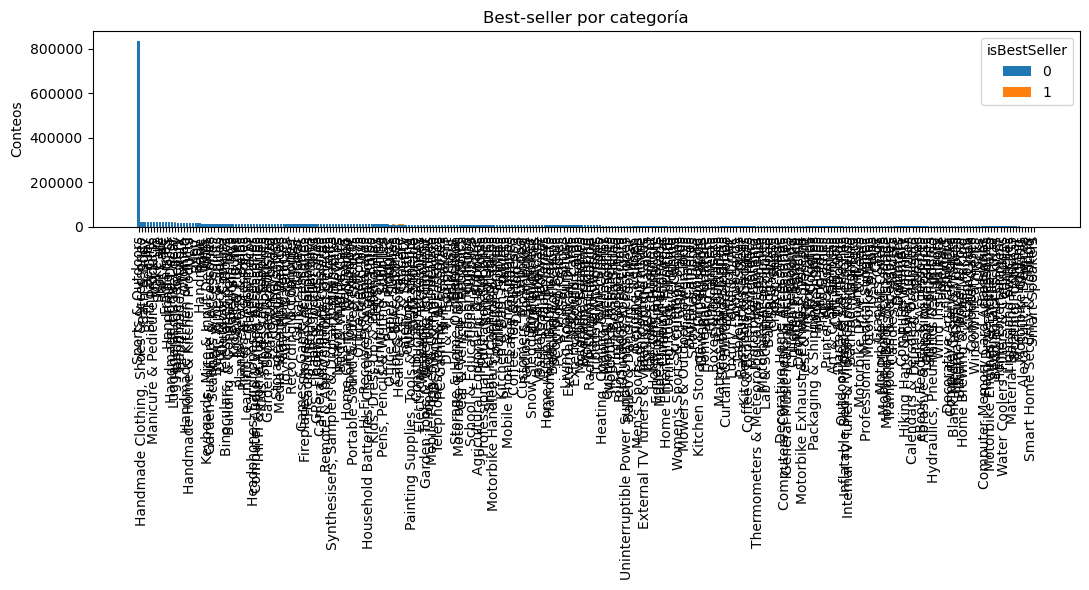

In [36]:
# === 5) Barras apiladas por categoría ===
ct_plot = ct.sort_values(by=ct.columns.tolist(), ascending=False)
cats = ct_plot.index.tolist()

plt.figure(figsize=(11,6))
bottom = np.zeros(len(cats))
for col in ct_plot.columns:
    vals = ct_plot[col].values
    plt.bar(cats, vals, bottom=bottom, label=str(col))
    bottom += vals

plt.xticks(rotation=90)
plt.ylabel("Conteos")
plt.title("Best-seller por categoría")
plt.legend(title=best_col)
plt.tight_layout()
plt.show()


In [37]:
# === 6) Filtro IQR en price ===
assert price_col, "Falta columna de precio"
mask = iqr_mask(df[price_col].dropna(), k=1.5)
# alinear índices
mask = df[price_col].notna() & df[price_col].between(df[price_col].quantile(0.25) - 1.5*(df[price_col].quantile(0.75)-df[price_col].quantile(0.25)),
                                                     df[price_col].quantile(0.75) + 1.5*(df[price_col].quantile(0.75)-df[price_col].quantile(0.25)))
df_wo = df.loc[mask].copy()
print("Original:", df.shape, "| Sin outliers de price:", df_wo.shape)


Original: (2443651, 9) | Sin outliers de price: (2115963, 9)


C:\Users\cubea\AppData\Local\Temp\ipykernel_25416\1368044892.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


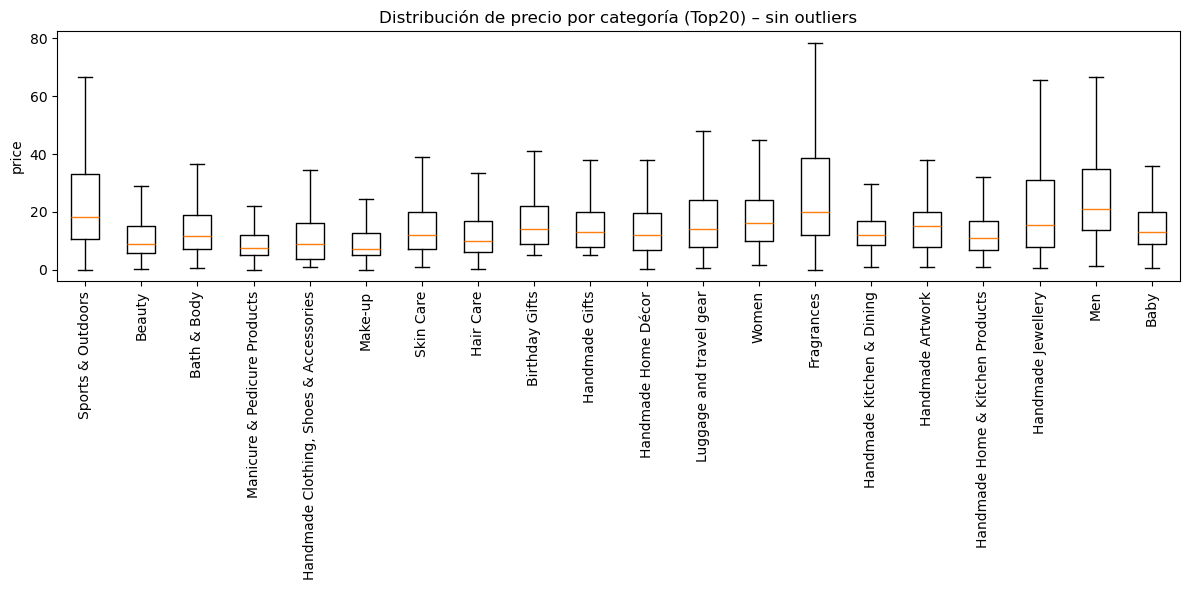

Top 10 medianas de precio por categoría (sin filtrar top):


category
Desktop PCs              74.000
Boxing Shoes             69.790
Tablets                  69.000
Graphics Cards           68.540
Motherboards             67.920
Made in Italy Handmade   64.000
Digital Frames           63.900
Streaming Clients        62.680
Golf Shoes               62.390
Ski Helmets              61.330
Name: price, dtype: float64

In [38]:
# === 7) Boxplots de price por categoría (Top20 por tamaño) ===
top20 = df_wo[cat_col].value_counts().head(20).index
sub = df_wo[df_wo[cat_col].isin(top20)]

cats = top20.tolist()
data = [sub.loc[sub[cat_col]==c, price_col].astype(float).dropna().values for c in cats]

plt.figure(figsize=(12,6))
plt.boxplot(data, labels=cats, showfliers=False)
plt.xticks(rotation=90)
plt.ylabel(price_col)
plt.title("Distribución de precio por categoría (Top20) – sin outliers")
plt.tight_layout()
plt.show()

median_by_cat_all = df_wo.groupby(cat_col)[price_col].median().sort_values(ascending=False)
print("Top 10 medianas de precio por categoría (sin filtrar top):")
display(median_by_cat_all.head(10))


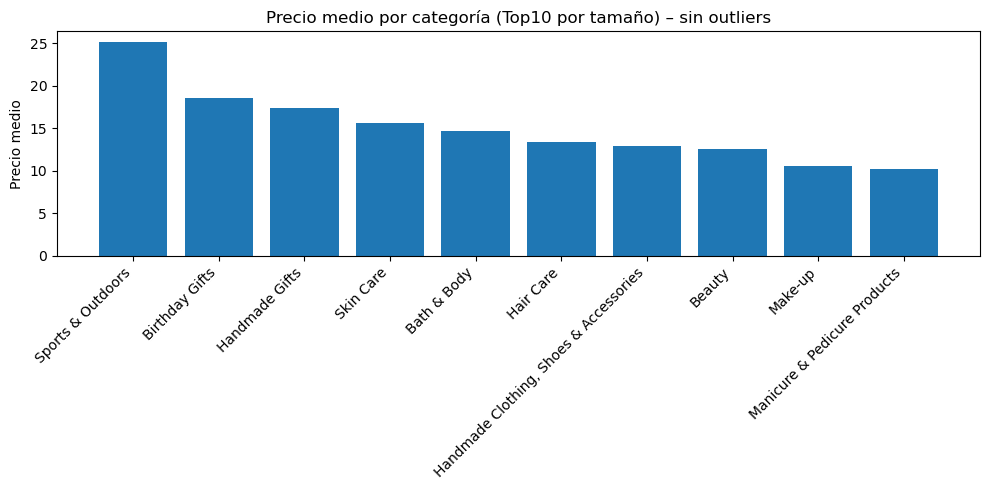

Top 10 promedios de precio por categoría (todas):


category
Motherboards        68.772
Boxing Shoes        67.418
Desktop PCs         66.916
Tablets             66.553
Graphics Cards      65.104
Digital Frames      60.745
Streaming Clients   60.242
Hockey Shoes        60.095
Computer Cases      58.340
Skiing Poles        57.868
Name: price, dtype: float64

In [39]:
# === 8) Precio medio por categoría ===
top10 = df_wo[cat_col].value_counts().head(10).index
sub10 = df_wo[df_wo[cat_col].isin(top10)]
mean_price_top = sub10.groupby(cat_col)[price_col].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
plt.bar(mean_price_top.index, mean_price_top.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Precio medio")
plt.title("Precio medio por categoría (Top10 por tamaño) – sin outliers")
plt.tight_layout()
plt.show()

mean_price_all = df_wo.groupby(cat_col)[price_col].mean().sort_values(ascending=False)
print("Top 10 promedios de precio por categoría (todas):")
display(mean_price_all.head(10))


C:\Users\cubea\AppData\Local\Temp\ipykernel_25416\1472291684.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


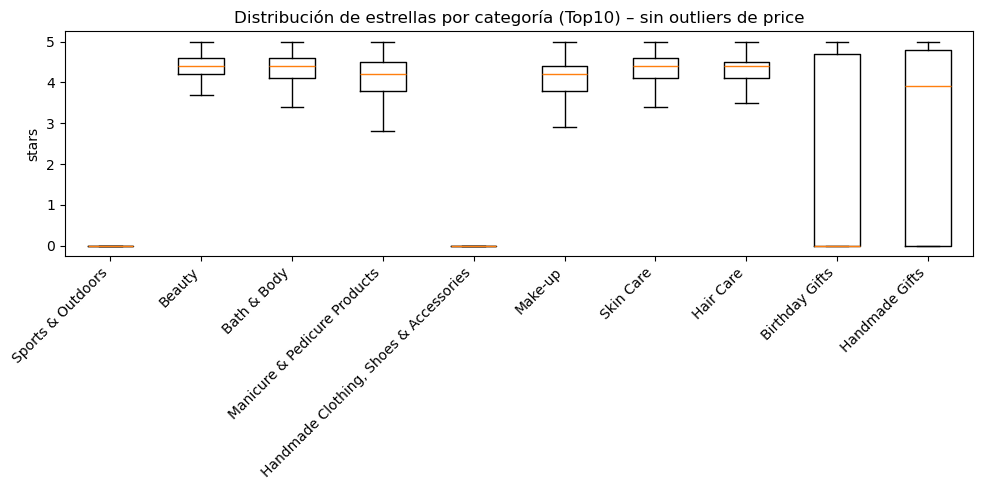

Top 10 medianas de stars por categoría (todas):


category
Computer Memory                4.700
Kids' Play Figures             4.600
Beer, Wine & Spirits           4.600
Office Paper Products          4.600
Luxury Food & Drink            4.600
Building & Construction Toys   4.600
Laptop Accessories             4.600
Hobbies                        4.600
Computer & Server Racks        4.500
Signs & Plaques                4.500
Name: stars, dtype: float64

In [40]:
# === 9) Boxplots de stars por categoría (Top10 por tamaño) ===
assert stars_col, "Falta columna de stars/ratings"

top10 = df_wo[cat_col].value_counts().head(10).index
sub = df_wo[df_wo[cat_col].isin(top10)]
cats = top10.tolist()
data = [sub.loc[sub[cat_col]==c, stars_col].astype(float).dropna().values for c in cats]

plt.figure(figsize=(10,5))
plt.boxplot(data, labels=cats, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.ylabel(stars_col)
plt.title("Distribución de estrellas por categoría (Top10) – sin outliers de price")
plt.tight_layout()
plt.show()

median_stars_all = df_wo.groupby(cat_col)[stars_col].median().sort_values(ascending=False)
print("Top 10 medianas de stars por categoría (todas):")
display(median_stars_all.head(10))


In [41]:
# === 10) Correlaciones price vs stars ===
num = df_wo[[price_col, stars_col]].dropna().astype(float)
pear_r, pear_p = pearsonr(num[price_col], num[stars_col])
spear_r, spear_p = spearmanr(num[price_col], num[stars_col])

print(f"Pearson r = {pear_r:,.4f} (p={pear_p:.6f})")
print(f"Spearman r = {spear_r:,.4f} (p={spear_p:.6f})")


Pearson r = -0.0777 (p=0.000000)
Spearman r = -0.0668 (p=0.000000)


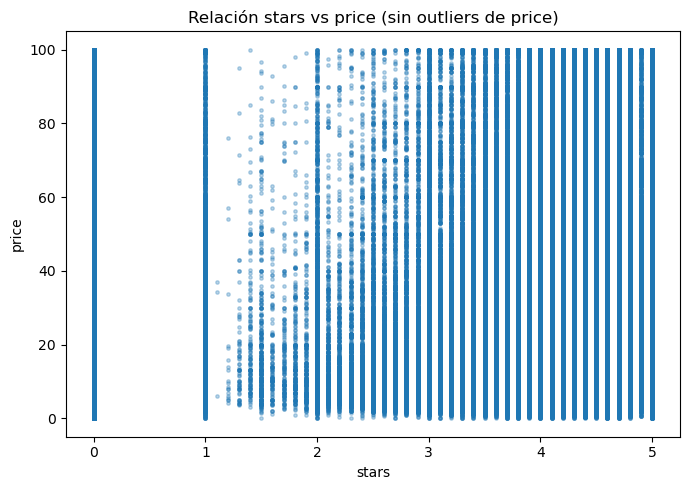

In [42]:
# === 11) Scatter ===
plt.figure(figsize=(7,5))
plt.scatter(df_wo[stars_col], df_wo[price_col], s=6, alpha=0.3)
plt.xlabel(stars_col)
plt.ylabel(price_col)
plt.title("Relación stars vs price (sin outliers de price)")
plt.tight_layout()
plt.show()


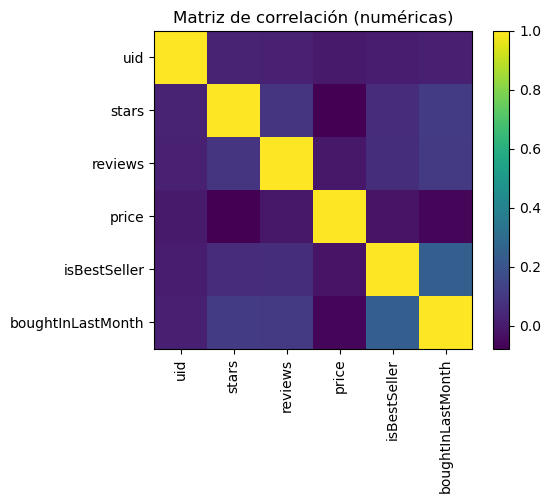

,uid,stars,reviews,price,isBestSeller,boughtInLastMonth
uid,1.000,0.030,0.020,0.002,0.003,0.017
stars,0.030,1.000,0.084,-0.078,0.059,0.114
reviews,0.020,0.084,1.000,-0.008,0.065,0.106
price,0.002,-0.078,-0.008,1.000,-0.019,-0.059
isBestSeller,0.003,0.059,0.065,-0.019,1.000,0.243
boughtInLastMonth,0.017,0.114,0.106,-0.059,0.243,1.000


In [43]:
# === 12) Matriz de correlación (todas numéricas) ===
num_all = df_wo.select_dtypes(include=[np.number]).dropna(axis=1, how='all')
corr = num_all.corr()

plt.figure(figsize=(6,5))
plt.imshow(corr, cmap=None)  # sin especificar paleta
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Matriz de correlación (numéricas)")
plt.tight_layout()
plt.show()

corr.round(3)


<Figure size 600x600 with 0 Axes>

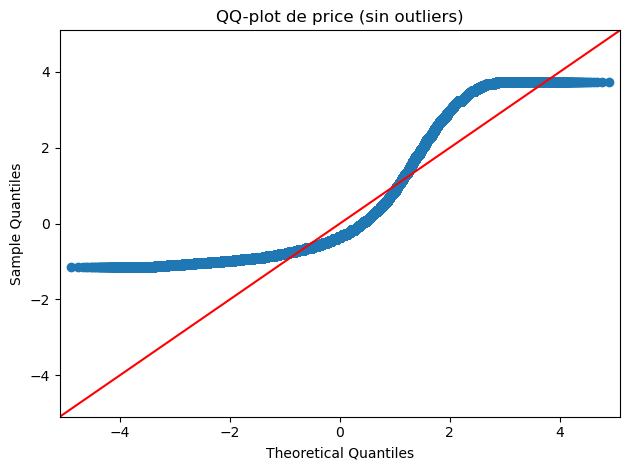

In [44]:
# === 13) QQ-plot de price ===
plt.figure(figsize=(6,6))
sm.qqplot(df_wo[price_col].dropna().astype(float), line='45', fit=True)
plt.title("QQ-plot de price (sin outliers)")
plt.tight_layout()
plt.show()


In [45]:
from IPython.display import Markdown, display

chi2_text = f"- **Asociación categoría–best-seller**: Chi² p=...; **Cramér’s V** ≈ ... (completa con tus valores)."
cat_top_bs = " / ".join((ct.div(ct.sum(axis=1), axis=0)[1].sort_values(ascending=False).head(5).index) if 1 in ct.columns else [])
median_top_price = " / ".join(median_by_cat_all.head(5).index)
mean_top_price   = " / ".join(mean_price_all.head(5).index)
median_top_stars = " / ".join(median_stars_all.head(5).index)

md = f"""
### Resumen ejecutivo
- **Categorías con mayor proporción de best-sellers**: {cat_top_bs}.
{chi2_text}
- **Precio por categoría**: *Medianas* top → {median_top_price}. *Medias* top → {mean_top_price}.
- **Valoraciones (stars)**: *Medianas* top → {median_top_stars}.
- **Relación price–stars**: Pearson/Spearman — interpreta la magnitud y significancia; ¿hay correlación relevante?
- **Implicaciones**: propuestas de pricing, surtido y posicionamiento por categoría.
"""
display(Markdown(md))



### Resumen ejecutivo
- **Categorías con mayor proporción de best-sellers**: Grocery / Smart Home Security & Lighting / Health & Personal Care / Mobile Phone Accessories / Power & Hand Tools.
- **Asociación categoría–best-seller**: Chi² p=...; **Cramér’s V** ≈ ... (completa con tus valores).
- **Precio por categoría**: *Medianas* top → Desktop PCs / Boxing Shoes / Tablets / Graphics Cards / Motherboards. *Medias* top → Motherboards / Boxing Shoes / Desktop PCs / Tablets / Graphics Cards.
- **Valoraciones (stars)**: *Medianas* top → Computer Memory / Kids' Play Figures / Beer, Wine & Spirits / Office Paper Products / Luxury Food & Drink.
- **Relación price–stars**: Pearson/Spearman — interpreta la magnitud y significancia; ¿hay correlación relevante?
- **Implicaciones**: propuestas de pricing, surtido y posicionamiento por categoría.
